In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
from pprint import pprint 

import datetime

from sklearn.model_selection import train_test_split


from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score

# 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from keras.models import Sequential, Model 
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from keras.utils import to_categorical

import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler

2024-07-03 01:19:32.224362: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-03 01:19:32.229169: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-03 01:19:32.246747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 01:19:32.280879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 01:19:32.280934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 01:19:32.302771: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
df = pd.read_csv('Datasets/dataset_32.csv')

In [3]:
df

,Unnamed: 0,1985-01-01 00:00:00,1985-02-01 00:00:00,1985-03-01 00:00:00,1985-04-01 00:00:00,1985-05-01 00:00:00,1985-06-01 00:00:00,1985-07-01 00:00:00,1985-08-01 00:00:00,1985-09-01 00:00:00,...,2023-03-01 00:00:00,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00,2023-07-01 00:00:00,2023-08-01 00:00:00,2023-09-01 00:00:00,2023-10-01 00:00:00,2023-11-01 00:00:00,2023-12-01 00:00:00
0,NACIONAL,36.0,16.5,15.0,37.2,51.5,126.9,139.8,118.8,106.1,...,15.9,15.4,40.0,39.2,99.8,111.4,65.9,95.7,50.4,26.7


In [4]:
# Establecer la columna 'Unnamed: 0' como el índice
df.set_index('Unnamed: 0', inplace=True)

# Transponer el dataframe para que las fechas sean el índice
df = df.transpose()

In [5]:
df = df.rename(columns={'NACIONAL' : 'MM/Mensual'})

In [6]:
fig = go.Figure()

# Añadir la línea de Ethereum
fig.add_trace(go.Scatter(x=df.index, y=df['MM/Mensual'], mode='lines', name='Precipitacion'))

# Configurar el formato del eje x para las fechas
fig.update_xaxes(
    tickformat='%Y-%m-%d',
    tickmode='auto',
    nticks=20  # ajusta este valor según la cantidad de etiquetas de fecha que quieras mostrar
)

# Añadir títulos y etiquetas
fig.update_layout(
    title='Gráfico de Serie de Tiempo Precipitacion Pluvial Nacional',
    xaxis_title='Fecha',
    yaxis_title='Valor',
    legend_title='Leyenda',
    width=1400,
    height=600
)

# Mostrar el gráfico
fig.show()

/tmp/ipykernel_3379455/4160741632.py:13: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



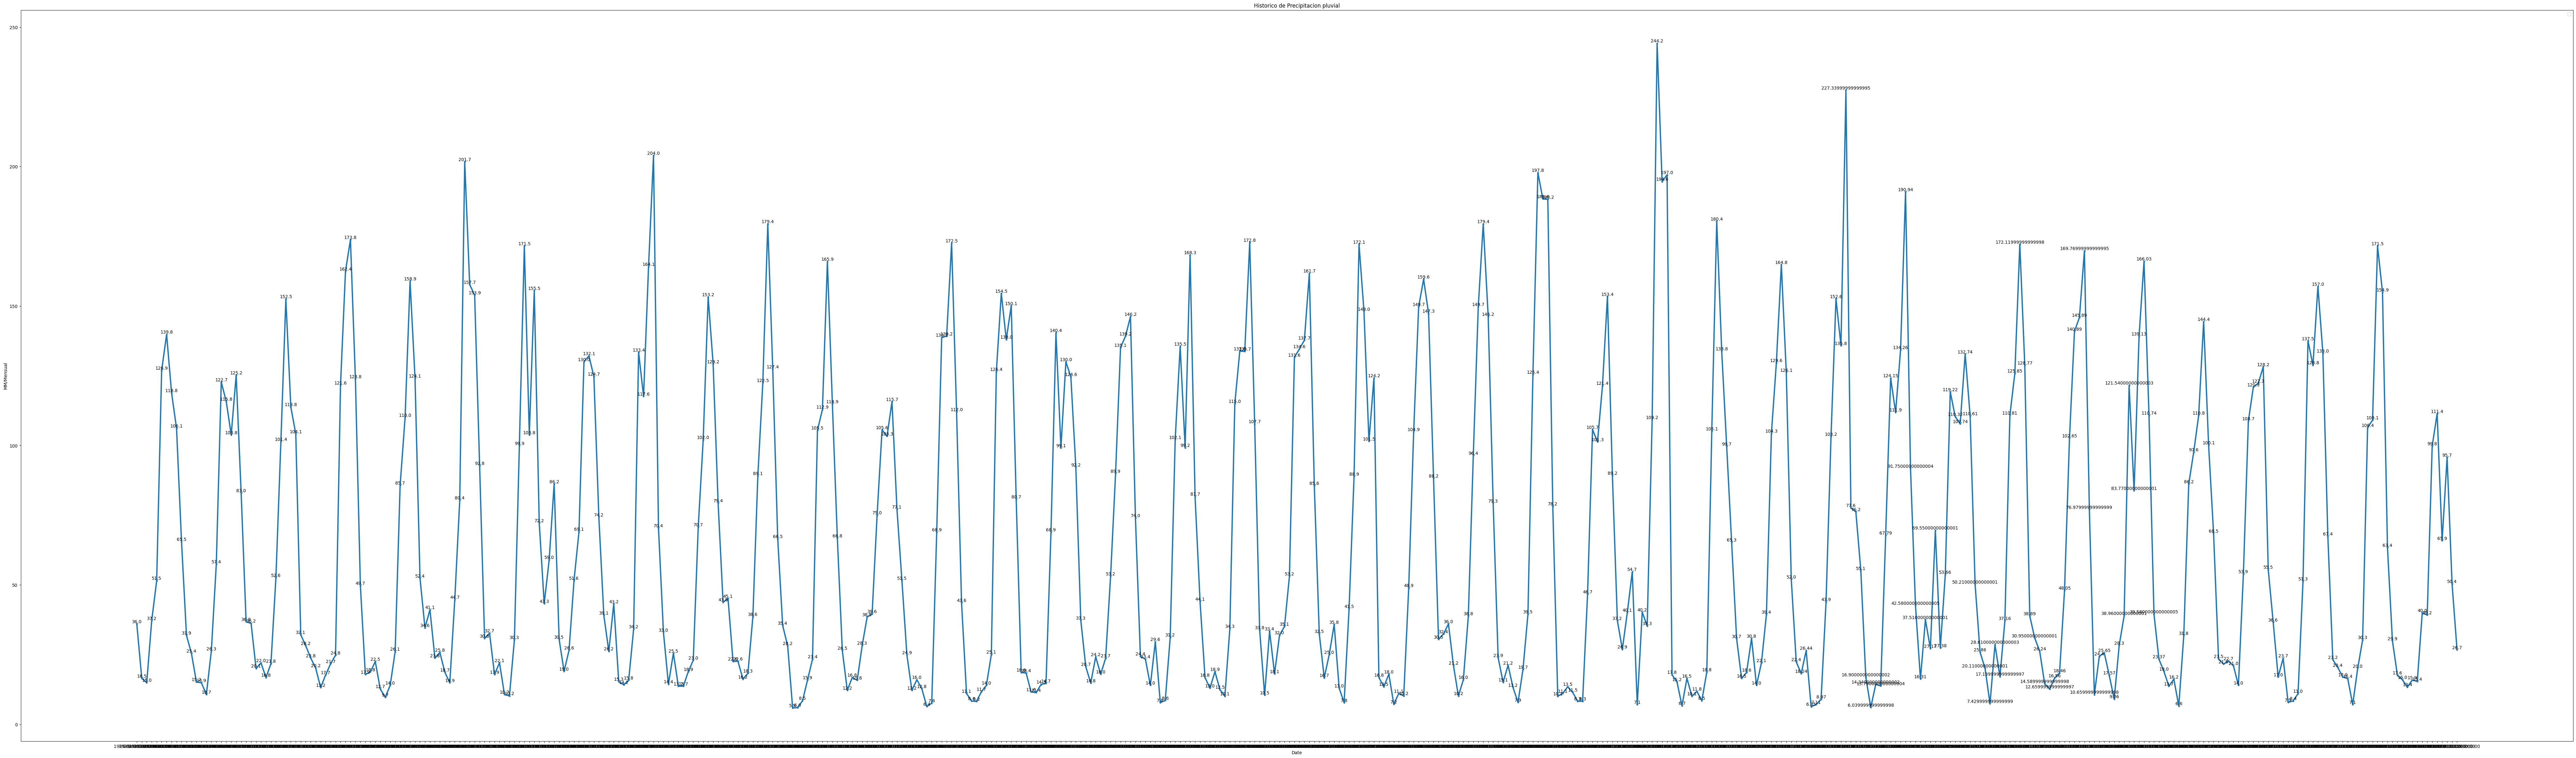

In [7]:
#### Ploteamos esto con Matplotlib........

plt.figure(figsize=(104,30))

plt.plot(df['MM/Mensual'], '.-', linewidth = 3)

for i, value in df['MM/Mensual'].items():
    plt.text(i, value, str(value), ha = 'center', va = 'bottom')

plt.title('Historico de Precipitacion pluvial')
plt.xlabel('Date')
plt.ylabel('MM/Mensual')
plt.legend()
plt.show()

In [8]:
df_visual = df['MM/Mensual'].copy()

In [9]:
df_values = df['MM/Mensual']
df_values = df_values.values

df_values = df_values.reshape(-1,1)

### Encoder MinMax(0,1)

In [10]:
scaler = MinMaxScaler()
df_values = scaler.fit_transform(df)

In [11]:
len(df)

468

In [12]:
train = df_values[:370]
test = df_values[370:]

## LSTM GOES BRUH

In [13]:
look_behind = 1

totalseq_i = []
totalseq_o = []

train_i = []
train_o = []

test_i = []
test_o = []

for i in range(len(train)-look_behind):
    train_i.append(train[i:i + look_behind])
    train_o.append(train[i + look_behind: i + look_behind + 1])
    

for i in range(len(test)- look_behind):
    test_i.append(test[i: i + look_behind])
    test_o.append(test[i + look_behind: i + look_behind + 1])
    
for i in range(len(test) - look_behind):
    totalseq_i.append(df_values[i: i + look_behind])
    totalseq_o.append(df_values[i + look_behind: i + look_behind + 1])

#### Ahora toca hacerles reshapes a las sequencias

In [14]:
train_i = np.reshape(train_i, (len(train_i),1, look_behind))
test_i = np.reshape(test_i, (len(test_i), 1, look_behind))

train_o = np.reshape(train_o, (len(train_o), 1))
test_o = np.reshape(test_o, (len(test_i), 1))

totalseq_i = np.reshape(totalseq_i, (len(totalseq_i), 1 , look_behind))
totalseq_o = np.reshape(totalseq_o, (len(totalseq_o), 1))

In [15]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (1,look_behind)))

model.add(Dense(32))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mae')
model.summary()

model.fit(train_i, train_o, batch_size=16, epochs=100)

/home/angel/Documentos/RainWise/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,065 (172.13 KB)

 Trainable params: 44,065 (172.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2236
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1660 
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1472 
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1214 
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1132 
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1278 
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1148 
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1210 
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1120 
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1228 
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1188 
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1225 
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1121 
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1196 
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1286 
Ep

In [16]:
history = model.history

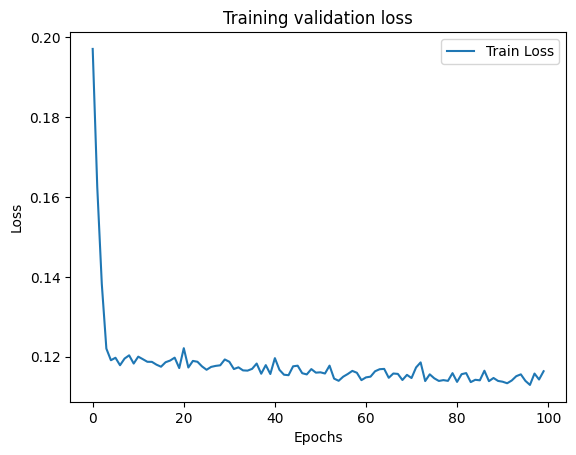

In [17]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.title('Training validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
predictions = model.predict(test_i)

totaltimeseries = df_visual
predicitions_train = model.predict(train_i) #### Valores de Predicction

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [19]:
predictions = scaler.inverse_transform(predictions)
predicitions_train = scaler.inverse_transform(predicitions_train)

predictions,predicitions_train

(array([[ 55.26903 ],
        [ 28.975952],
        [ 24.801708],
        [ 17.702993],
        [ 31.172174],
        [ 22.715456],
        [ 40.04075 ],
        [124.100746],
        [130.82579 ],
        [148.08734 ],
        [132.03813 ],
        [ 42.0624  ],
        [ 33.251476],
        [ 29.259706],
        [ 20.971184],
        [ 19.652044],
        [ 22.317148],
        [ 23.642826],
        [ 52.75196 ],
        [116.05527 ],
        [136.89317 ],
        [138.81293 ],
        [147.31102 ],
        [ 86.38351 ],
        [ 18.482576],
        [ 27.885592],
        [ 28.819136],
        [ 23.017582],
        [ 18.06175 ],
        [ 30.899397],
        [ 42.144188],
        [129.00618 ],
        [ 94.251015],
        [136.20586 ],
        [146.05336 ],
        [124.06185 ],
        [ 42.868484],
        [ 27.116222],
        [ 24.022139],
        [ 20.362938],
        [ 22.071226],
        [ 17.579987],
        [ 34.070347],
        [ 97.06331 ],
        [110.23343 ],
        [1

In [20]:
predicitions_train = np.reshape(predicitions_train, len(predicitions_train))
predictions = np.reshape(predictions, len(predictions))

In [21]:
df_visual = df_visual.reset_index()

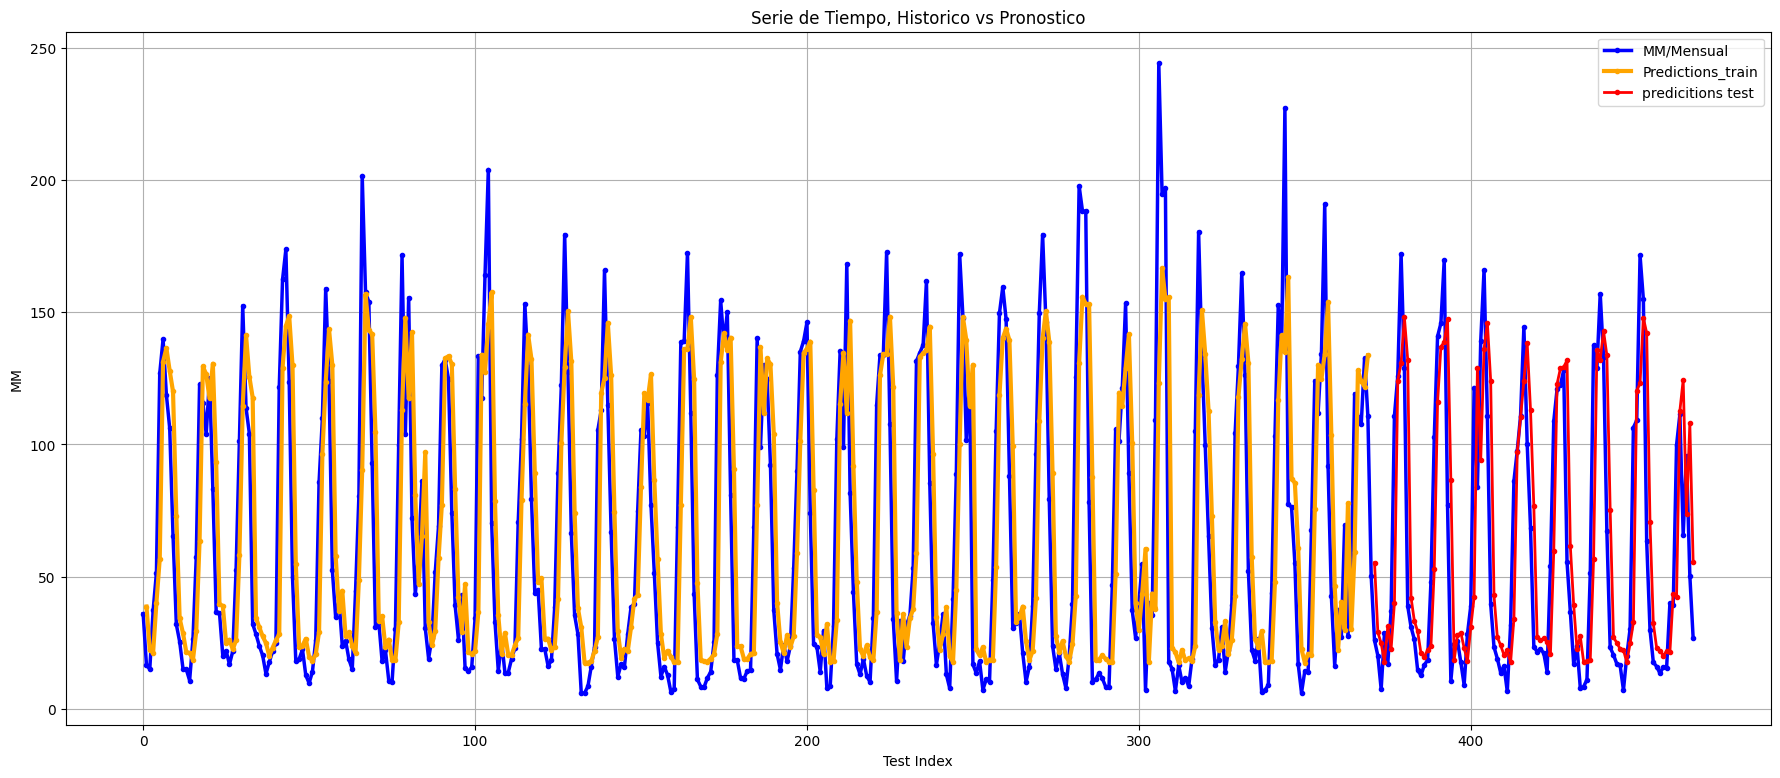

In [22]:
plt.figure(figsize=(22,9))
s1 = [1 + j for j in range(len(predicitions_train))]
plt.plot(df_visual['MM/Mensual'], '.-', label = 'MM/Mensual', color = 'blue', linewidth = 2.5)
s2 = [371 + j for j in range(len(predictions))]
plt.plot(s1, predicitions_train, '.-', color = 'orange', label = 'Predictions_train', linewidth = 3)
plt.plot(s2, predictions, '.-', color = 'red', label = 'predicitions test', linewidth = 2)

plt.title('Serie de Tiempo, Historico vs Pronostico')
plt.xlabel('Test Index')
plt.ylabel('MM')
plt.grid(True)

plt.legend()
plt.show()

In [23]:
auxtrain = pd.DataFrame(predicitions_train)
auxpred = pd.DataFrame(predictions)

In [24]:
df_final = pd.concat([auxtrain, auxpred])
auxnan = pd.DataFrame({'values': [np.nan]})

In [25]:
df_final = pd.concat([auxnan, df_final])
df_final = df_final[0]
df_final = pd.DataFrame(df_final)
df_final = df_final.reset_index()
df_final = pd.DataFrame(df_final[0])

In [26]:
df_final

,0
0,NaN
1,38.684792
2,22.276163
3,21.251350
4,40.087502
...,...
462,112.770607
463,124.428154
464,73.517845
465,108.041077


In [27]:
auxindex = df.index
auxindex = pd.DataFrame(auxindex)

auxindex = auxindex.iloc[1:]

# Resetear el índice
auxindex.reset_index(drop=True, inplace=True)

In [28]:
####Crear una columna de fechas
df_final['date'] = auxindex[0]

In [29]:
df_final

,0,date
0,NaN,1985-02-01 00:00:00
1,38.684792,1985-03-01 00:00:00
2,22.276163,1985-04-01 00:00:00
3,21.251350,1985-05-01 00:00:00
4,40.087502,1985-06-01 00:00:00
...,...,...
462,112.770607,2023-08-01 00:00:00
463,124.428154,2023-09-01 00:00:00
464,73.517845,2023-10-01 00:00:00
465,108.041077,2023-11-01 00:00:00


In [30]:
df_view = df.copy()
df_view = df_view.reset_index()

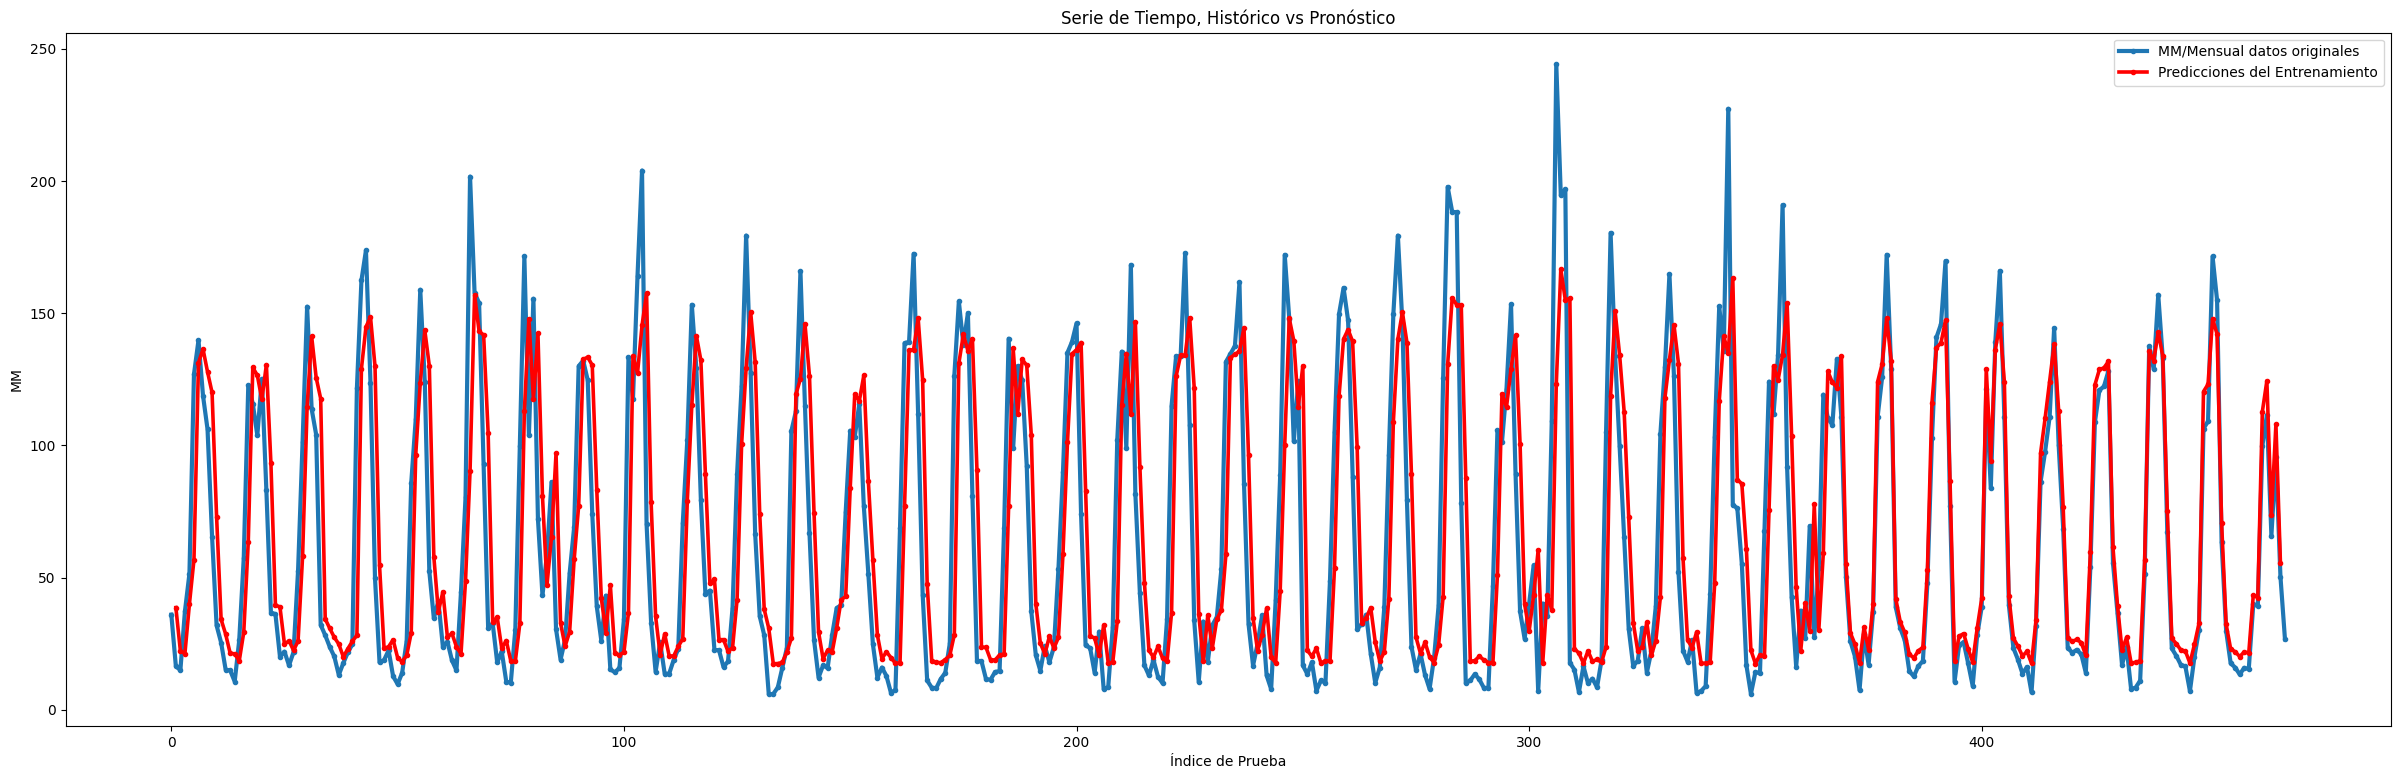

In [31]:
plt.figure(figsize=(30, 9))
plt.plot(df_view.index, df_view['MM/Mensual'], '.-', linewidth=3, label='MM/Mensual datos originales') 
plt.plot(df_final.index, df_final[0], '.-', linewidth = 2.6, label = 'Predicciones del Entrenamiento', color = 'red')
plt.title('Serie de Tiempo, Histórico vs Pronóstico')
plt.xlabel('Índice de Prueba')
plt.ylabel('MM')
plt.grid(False)  # Corregido: cambiado a True para mostrar la cuadrícula

plt.legend()
plt.show()

In [32]:
Total_Seq = df_final[0]
Total_Seq = Total_Seq.values
Total_Seq = Total_Seq.reshape(-1,1)

In [33]:
look_behind = 1

In [34]:
Total_Seq = scaler.fit_transform(Total_Seq)
Total_Seq

array([[           nan],
       [1.42141670e-01],
       [3.21695730e-02],
       [2.53011808e-02],
       [1.51542753e-01],
       [2.63361305e-01],
       [7.62613416e-01],
       [7.97494829e-01],
       [7.39605129e-01],
       [6.87312603e-01],
       [3.72480184e-01],
       [1.11886747e-01],
       [7.47699067e-02],
       [2.62170658e-02],
       [2.48432085e-02],
       [6.83315843e-03],
       [7.92741701e-02],
       [3.09378505e-01],
       [7.50789642e-01],
       [7.30867386e-01],
       [6.69563770e-01],
       [7.57855296e-01],
       [5.08576512e-01],
       [1.48409158e-01],
       [1.43708140e-01],
       [4.90489379e-02],
       [5.79896495e-02],
       [3.35430130e-02],
       [5.70486709e-02],
       [2.71945983e-01],
       [6.51032150e-01],
       [8.29718769e-01],
       [7.24977374e-01],
       [6.71879351e-01],
       [1.13229670e-01],
       [8.93932208e-02],
       [6.67608306e-02],
       [4.95195910e-02],
       [1.70564577e-02],
       [3.77507433e-02],


In [35]:
last_point = Total_Seq[-look_behind:].reshape(1,1,look_behind)
next_predictions = []

In [36]:
for _ in range(24): #Nexus point for the forecast
    #Forecast the next point in the set
    next_pred = model.predict(last_point)
    next_predictions.append(next_pred[0, 0])
    
    ########Update the last points with the new predictions
    last_point = np.roll(last_point, -1)
    last_point[0, 0, -1] = next_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipykernel_3379455/1750099382.py:8: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [37]:
next_predictions
next_predictions = np.array(next_predictions)
next_predictions = next_predictions.reshape(-1,1)
next_predictions = scaler.inverse_transform(next_predictions)
next_predictions = pd.DataFrame(next_predictions)
Total_Seq = scaler.inverse_transform(Total_Seq)

In [38]:
Total_Seq = pd.DataFrame(Total_Seq)
concatenated_dfpred = pd.concat([Total_Seq, next_predictions], ignore_index=True)

In [39]:
concatenated_dfpred.rename(columns={0: 'Predictions'}, inplace=True)
concatenated_dfpred.head()

,Predictions
0,NaN
1,38.684792
2,22.276165
3,21.251350
4,40.087502


In [40]:
dates_auxindex = pd.date_range(start='1985-02-01', periods= len(concatenated_dfpred), freq='M')
concatenated_dfpred.index = dates_auxindex
concatenated_dfpred

/tmp/ipykernel_3379455/2706062519.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



,Predictions
1985-02-28,NaN
1985-03-31,38.684792
1985-04-30,22.276165
1985-05-31,21.251350
1985-06-30,40.087502
...,...
2025-08-31,97.859741
2025-09-30,97.859741
2025-10-31,97.859741
2025-11-30,97.859741


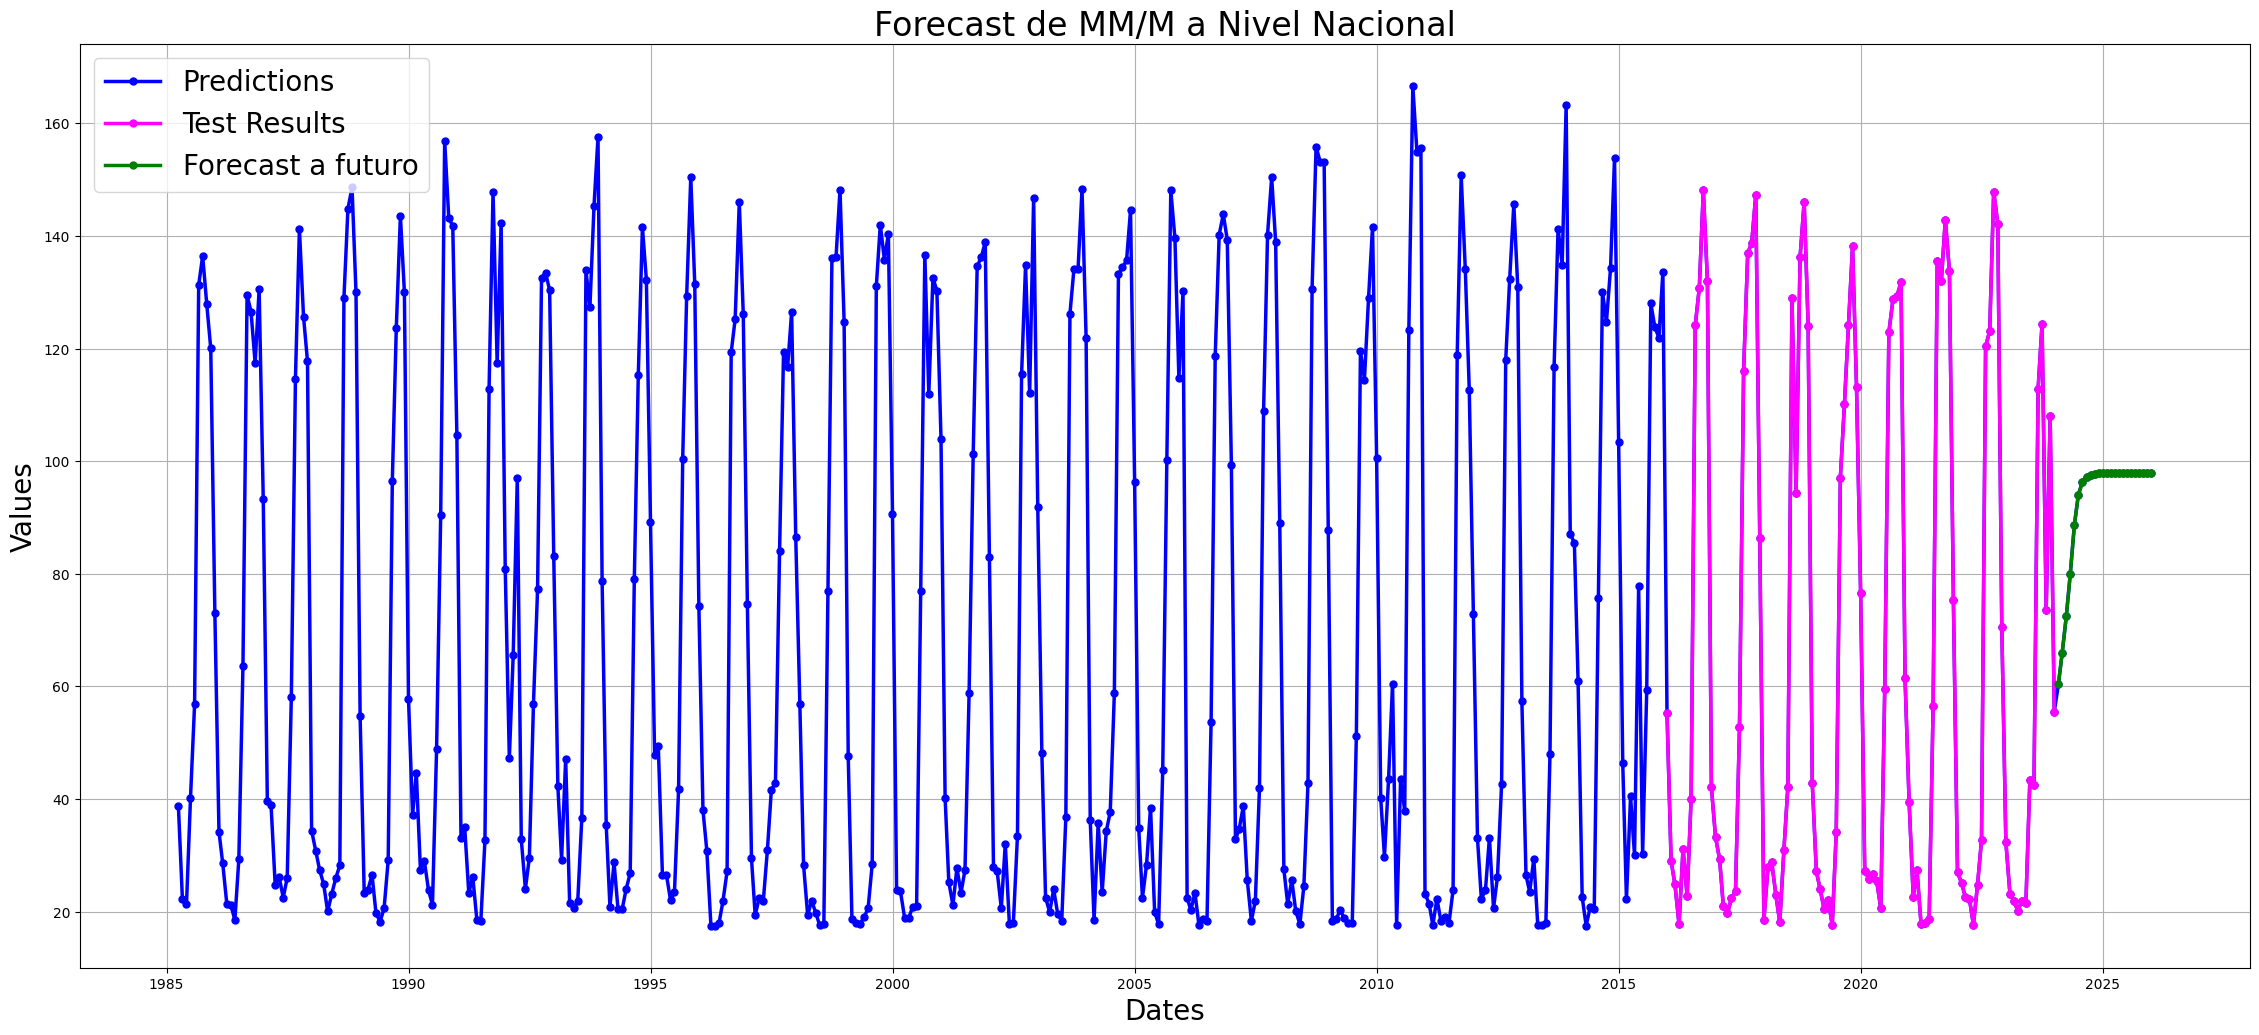

In [41]:
plt.figure(figsize=(28, 12))
plt.plot(concatenated_dfpred['Predictions'],'.-' , label='Predictions', color = 'Blue', linewidth=2.5, markersize=10)
plt.plot(concatenated_dfpred['Predictions'].iloc[370:467], '.-' , label='Test Results', color = 'Fuchsia', linewidth=2.5, markersize=10)
plt.plot(concatenated_dfpred.iloc[467:],'.-' , label='Forecast a futuro', color = 'Green', linewidth=2.5, markersize=10)

plt.title('Forecast de MM/M a Nivel Nacional', fontsize=24)
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Values', fontsize=20)
plt.grid(True)



#plt.axvline(x=testline, color='black', linestyle='--', linewidth=2.5)
#plt.text(test_text, plt.gca().get_ylim()[1], 'Test', ha='right', va='top', rotation='horizontal',fontsize=18)

#plt.axvline(x=forecastline, color='magenta', linestyle='--', linewidth=2.5)
#plt.text(forecasttext, plt.gca().get_ylim()[1], 'Forecast', ha = 'left', va='top', rotation='horizontal', fontsize=18)




#axvline('30', color='red', ls='--')
plt.legend(fontsize=20)
plt.show()

In [42]:
concatenated_dfpred.to_csv('PrediccionesLSTM_NACIONAL.csv', index=False)

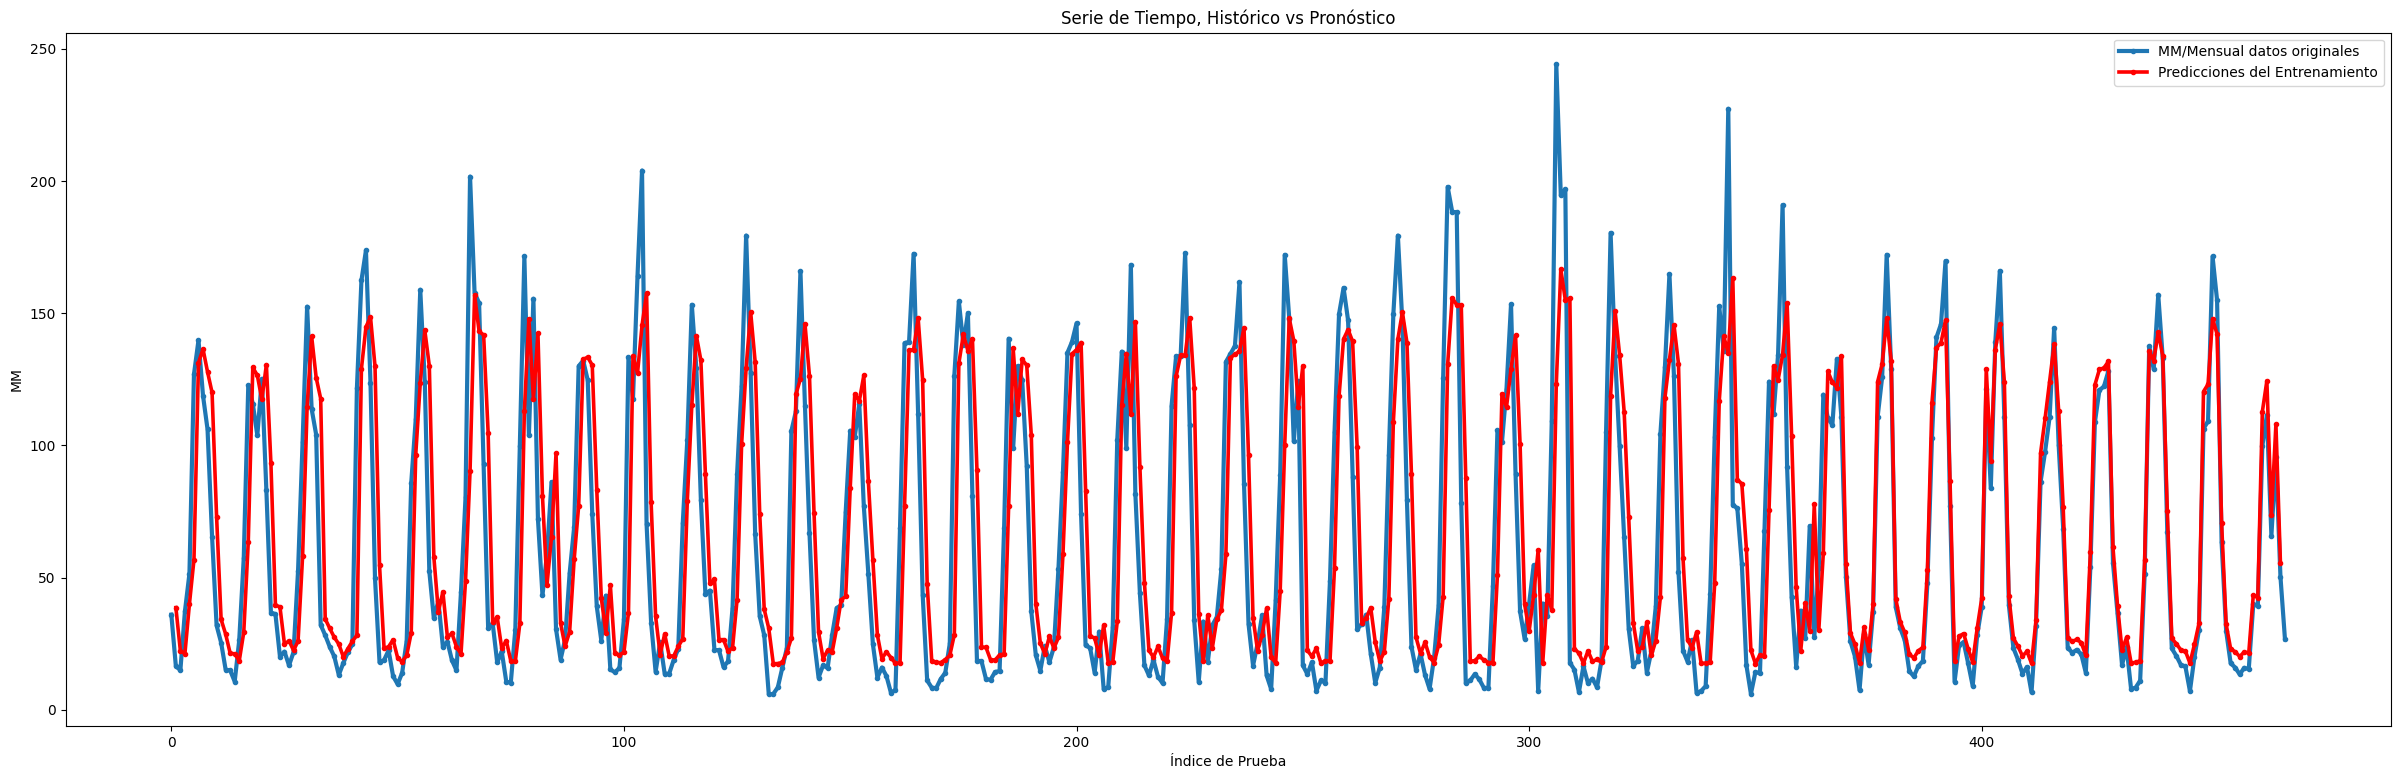

In [45]:
plt.figure(figsize=(30, 9))
plt.plot(df_view.index, df_view['MM/Mensual'], '.-', linewidth=3, label='MM/Mensual datos originales') 
plt.plot(df_final.index, df_final[0], '.-', linewidth = 2.6, label = 'Predicciones del Entrenamiento', color = 'red')
plt.title('Serie de Tiempo, Histórico vs Pronóstico')
plt.xlabel('Índice de Prueba')
plt.ylabel('MM')
plt.grid(False) 

plt.legend()
plt.show()

In [ ]:
df_final.to_csv('HistoricoTrainingLSTM_Nacional.csv', index=False)